##### Classificação de Gênero Musical Utilizando Machine Learning

O desafio deste é criar um modelo de “machine learning” que prediz qual gênero
de uma música somente baseado na letra dela.
O modelo será construído utilizando alguns conceitos de NLP (Processamento de
Linguagem Natural) junto a conceitos estatísticos simples. Os dados serão retirados de
uma base do “Kaggle” contendo uma vasta gama de músicas em português e inglês.
Para esse desafio recomenda-se fortemente trabalhar com uma só dessas línguas.
Extra: É interessante também visualizar quais as palavras mais comuns de cada
gênero

##### Etapas

- Aprender o que são e como aplicar conceitos de NLP
    - Tokenização
    - Limpeza com expressões regulares
    - Remoção de stopwords
    - Stemming
    - Lemmatization
    - Vetorização<br/><br>
    
- Aprender como funciona e como aplicar o modelo Naive-Bayes e sua forma
multinomial para o uso nesse challenge

##### Importação dos dados

In [1]:
import pandas as pd

In [2]:
df_lyrics  = pd.read_csv("banco_dados/lyrics-data.csv")
df_artists = pd.read_csv("banco_dados/artists-data.csv")

In [3]:
print(f"Atributos do lyrics_data:     {df_lyrics.columns}")
print(f"Atributos do artists_data:    {df_artists.columns}")
print(f"Tamanho do Dataset (Lyrics):  {df_lyrics.shape}")
print(f"Tamanho do Dataset (Artists): {df_artists.shape}")

Atributos do lyrics_data:     Index(['ALink', 'SName', 'SLink', 'Lyric', 'language'], dtype='object')
Atributos do artists_data:    Index(['Artist', 'Genres', 'Songs', 'Popularity', 'Link'], dtype='object')
Tamanho do Dataset (Lyrics):  (379931, 5)
Tamanho do Dataset (Artists): (4168, 5)


Escolhendo as apenas as colunas importante para os problemas

In [4]:
important_columns = ['ALink', 'SName', 'Lyric', 'language']
df_lyrics = df_lyrics[important_columns]
#display(df_lyrics)

important_columns = ['Artist', 'Genres', 'Link']
df_artists = df_artists[important_columns]
#display(df_artists)

Juntando as duas colunas baseado no **ALink** do *df_lyrics* e **Link** do *df_artists*

In [5]:
df_processed = pd.merge(df_lyrics, df_artists, left_on='ALink', right_on='Link')
df_processed.drop(['ALink', 'Link'], axis=1, inplace=True)

In [6]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378988 entries, 0 to 378987
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   SName     378985 non-null  object
 1   Lyric     378911 non-null  object
 2   language  364402 non-null  object
 3   Artist    378987 non-null  object
 4   Genres    378948 non-null  object
dtypes: object(5)
memory usage: 17.3+ MB


Melhor remover os valores nulos pra uma análise mais precisa

In [7]:
df_processed.dropna(inplace=True)

Iremos trabalhar para esse caso apenas para casos de linguagem *en*

In [8]:
df_processed = df_processed[df_processed['language'] == 'en']

Agora é realizar o pre-processamento de texto, alterando as palavras pra minusculos e removendo as stopwords e pontuação

In [9]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

lemmatizer = WordNetLemmatizer()

def to_lower(lyrics):
    return lyrics.lower()

def remove_stopwords(lyrics):
    tokenized = word_tokenize(lyrics)
    stop_words = set(stopwords.words('english'))
    filtered_stop = [word for word in tokenized if word not in stop_words]
    return " ".join(filtered_stop)

def remove_punctuation(lyrics):
    tokenized = word_tokenize(lyrics)
    no_punctuation = [word for word in tokenized if word.isalpha()]
    return " ".join(no_punctuation)

def word_lemmatizer(lyrics):
    tokenized  = word_tokenize(lyrics)
    lemmatized = [lemmatizer.lemmatize(word) for word in tokenized]
    return " ".join(lemmatized)

In [10]:
tqdm.pandas()
df_processed['Lyric'] = df_processed['Lyric'] \
                        .progress_apply(to_lower) \
                        .progress_apply(remove_stopwords) \
                        .progress_apply(remove_punctuation) \
                        .progress_apply(word_lemmatizer)

100%|██████████| 191376/191376 [02:50<00:00, 1120.17it/s]


Pegar os gêneros fazendo um split dos elementos das colunas criando assim uma lista de listas

In [11]:
list_genres = df_processed['Genres'].str.split(';').values
genres = [g.strip() for genres in list_genres for g in genres]

In [12]:
from collections import Counter
result = {k: v for k, v in sorted(Counter(genres).items(), key=lambda item: item[1], reverse=True)}

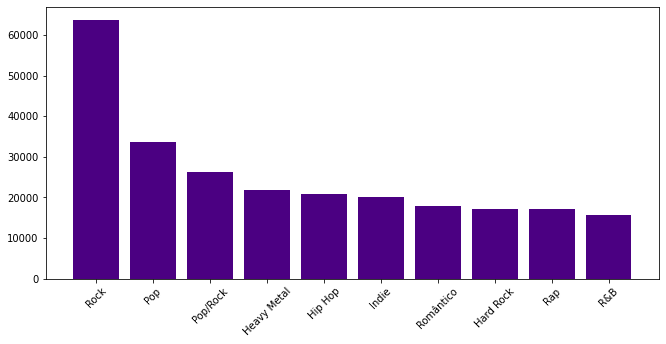

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11, 5))

names  = list(result.keys())[:10]
values = list(result.values())[:10]

plt.bar(range(10), values, tick_label=names, color='indigo')

plt.xticks(rotation = 45)
plt.show()

In [14]:
df_processed.drop(['language'], axis=1, inplace=True)
df_processed.head()

,SName,Lyric,Artist,Genres
69,Careless Whisper,feel unsure take hand lead dance floor music d...,Ivete Sangalo,Pop; Axé; Romântico
86,Could You Be Loved / Citação Musical do Rap: S...,let fool ya even try school ya oh got mind go ...,Ivete Sangalo,Pop; Axé; Romântico
88,Cruisin' (Part. Saulo),baby let cruise away confused way clear want g...,Ivete Sangalo,Pop; Axé; Romântico
111,Easy,know sound funny ca stand pain girl leaving to...,Ivete Sangalo,Pop; Axé; Romântico
140,For Your Babies (The Voice cover),got look one hoped lad face beaming smile got ...,Ivete Sangalo,Pop; Axé; Romântico


In [15]:
df_processed.to_csv("banco_dados/processed-data.csv", index=False)